In [16]:
import torch

from rl4co.envs import TSPEnv, PDPEnv, RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer

current node:  tensor([[13],
        [ 5]])
index:  tensor([[0],
        [0]])
first node:  tensor([0, 0])
end node:  tensor([19, 19])
current node:  tensor([[4],
        [4]])
index:  tensor([[1],
        [1]])
first node:  tensor([0, 0])
end node:  tensor([19, 19])
current node:  tensor([[15],
        [18]])
index:  tensor([[2],
        [2]])
first node:  tensor([0, 0])
end node:  tensor([19, 19])
current node:  tensor([[14],
        [11]])
index:  tensor([[3],
        [3]])
first node:  tensor([0, 0])
end node:  tensor([19, 19])
current node:  tensor([[9],
        [9]])
index:  tensor([[4],
        [4]])
first node:  tensor([0, 0])
end node:  tensor([19, 19])
current node:  tensor([[18],
        [17]])
index:  tensor([[5],
        [5]])
first node:  tensor([0, 0])
end node:  tensor([19, 19])
current node:  tensor([[16],
        [16]])
index:  tensor([[6],
        [6]])
first node:  tensor([0, 0])
end node:  tensor([19, 19])
current node:  tensor([[11],
        [ 7]])
index:  tensor(

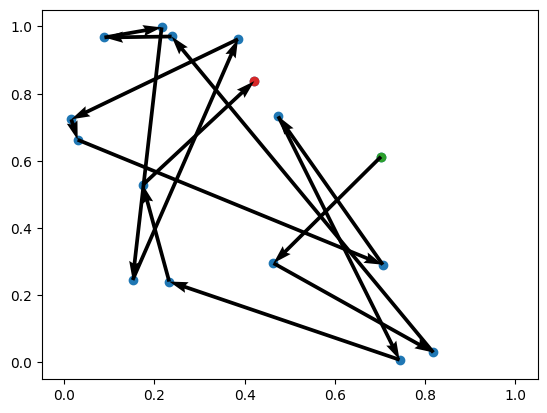

In [198]:
from typing import Optional
import torch
import torch.nn as nn

from tensordict.tensordict import TensorDict
from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.common.base import RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy
from rl4co.utils.ops import gather_by_index, get_tour_length
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.pylogger import get_pylogger
log = get_pylogger(__name__)

def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    """Reset the environment to the initial state"""
    # If no TensorDict is provided, generate a new one
    init_locs = td["locs"] if td is not None else None
    # If no batch_size is provided, use the batch_size of the initial locations
    if batch_size is None:
        batch_size = self.batch_size if init_locs is None else init_locs.shape[:-2]
    # If no device is provided, use the device of the initial locations
    device = init_locs.device if init_locs is not None else self.device 
    self.to(device)
    # If no initial locations are provided, generate new ones
    if init_locs is None:
        init_locs = self.generate_data(batch_size=batch_size).to(device)["locs"]
    # If batch_size is an integer, convert it to a list
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # Get the number of locations
    num_loc = init_locs.shape[-2]

    # Initialize a start and end node
    first_node = torch.zeros((batch_size), dtype=torch.int64, device=device)
    end_node = torch.full((batch_size), num_loc - 1, dtype=torch.int64, device=device)

    # represent the availability of each node in the environment for each batch
    available = torch.ones((*batch_size, num_loc), dtype=torch.bool, device=device)
    
    # Initialize the index of the current node 
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "locs": init_locs,
            "first_node": first_node,
            "current_node": first_node,
            "end_node": end_node,
            "i": i,
            "action_mask": available,
            "reward": torch.zeros((*batch_size, 1), dtype=torch.float32),
        },
        batch_size=batch_size,
    )

def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]

    # output visiting node
    print("current node: ", current_node.unsqueeze(-1))
    print("index: ", td["i"])
    print("first node: ", td["first_node"])
    print("end node: ", td["end_node"])
    first_node = current_node if td["i"].all() == 0 else td["first_node"]

    # Mark the current node as visited
    available = td["action_mask"].scatter(
        -1, current_node.unsqueeze(-1).expand_as(td["action_mask"]), 0
    )
 
    # output the mask
    # print("action mask: ", available)

    # available = td["action_mask"].scatter(
    #    -1, current_node.unsqueeze(-1).expand_as(td["action_mask"]), 0
    # )
    # print(current_node == td["end_node"])
    done = torch.any(torch.eq(current_node, td["end_node"])).expand_as(td["action"])
    
    # print("done: ", done)

    # The reward is calculated outside via get_reward for efficiency, so we set it to 0 here
    reward = torch.zeros_like(done)

    td.update(
        {
            # "first_node": first_node,
            "current_node": current_node,
            "i": td["i"] + 1,
            "action_mask": available,
            "reward": reward,
            "done": done,
        },
    )
    return td

def get_action_mask(self, td: TensorDict) -> TensorDict:
    # Here: your logic
    return td["action_mask"]

# def check_solution_validity(self, td: TensorDict, actions: torch.Tensor):
#     """Check that solution is valid: nodes are visited exactly once"""
#     assert (
#         torch.arange(actions.size(1), out=actions.data.new())
#         .view(1, -1)
#         .expand_as(actions)
#         == actions.data.sort(1)[0]
#     ).all(), "Invalid tour"

def get_reward(self, td, actions) -> TensorDict:
    # if self.check_solution:
    #     self.check_solution_validity(td, actions)
    # Reward the agent based on the length of the path from the start node to the end
    locs_ordered = gather_by_index(td["locs"], actions)

    # print("reward: ", reward)
    return -get_tour_length(locs_ordered)

def _make_spec(self, td_params):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            low=self.min_loc,
            high=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        start_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        end_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        shape=(),
    )
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        low=0,
        high=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

def generate_data(self, batch_size) -> TensorDict:
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    locs = (
        torch.rand((*batch_size, self.num_loc, 2), generator=self.rng)
        * (self.max_loc - self.min_loc)
        + self.min_loc
    )
    return TensorDict({"locs": locs}, batch_size=batch_size)

def render(self, td, actions=None, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        # Create a plot of the nodes
        _, ax = plt.subplots()

    td = td.detach().cpu()

    if actions is None:
        actions = td.get("action", None)
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]
        actions = actions[0]

    locs = td["locs"]

    # gather locs in order of action if available
    if actions is None:
        print("No action in TensorDict, rendering unsorted locs")
    else:
        actions = actions.detach().cpu()
        locs = gather_by_index(locs, actions, dim=0)

    # Cat the first node to the end to complete the tour
    # locs = torch.cat((locs, locs[0:1]))
    x, y = locs[:, 0], locs[:, 1]

    # Plot the visited nodes
    ax.scatter(x, y, color="tab:blue")

    print(td['first_node'].item())
    print(td['end_node'].item())

    # Highlight the start node in green
    ax.scatter(x[0], y[0], color="tab:green")

    # Highlight the end node in red
    ax.scatter(x[-1], y[-1], color="tab:red")

    # Add arrows between visited nodes as a quiver plot
    dx, dy = np.diff(x), np.diff(y)
    ax.quiver(
        x[:-1], y[:-1], dx, dy, scale_units="xy", angles="xy", scale=1, color="k"
    )

    # Setup limits and show
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

class SPPEnv(RL4COEnvBase):
    """Traveling Salesman Problem (TSP) environment"""

    name = "tsp"

    def __init__(
        self,
        num_loc: int = 20,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc
        self._make_spec(td_params)

    _reset = _reset
    _step = _step
    get_reward = get_reward
    # check_solution_validity = check_solution_validity
    get_action_mask = get_action_mask
    _make_spec = _make_spec
    generate_data = generate_data
    render = render

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0

    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
        steps += 1
        if steps > max_steps:
            log.info("Max steps reached")
            break
    return (
        env.get_reward(td, torch.stack(actions, dim=1)),
        td,
        torch.stack(actions, dim=1),
    )

# from rl4co.utils.decoding import rollout, random_policy

batch_size = 2

env = SPPEnv(num_loc=20)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
env.render(td, actions)

In [199]:
env = SPPEnv(num_loc=10)

policy = AttentionModelPolicy(env.name, 
                              embedding_dim=128, 
                              num_encoder_layers=3, 
                              num_heads=8,)

model = AttentionModel(env, baseline="rollout",
                       #batch_size=3,
                       train_data_size=100_000,
                       val_data_size=10_000,
                       optimizer_kwargs= {"lr": 1e-4},)

/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ECE5984_Deep_Reinforcement_Learning/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


current node:  tensor([[6],
        [7],
        [5]], device='cuda:0')
index:  tensor([[0],
        [0],
        [0]], device='cuda:0')
first node:  tensor([0, 0, 0], device='cuda:0')
end node:  tensor([9, 9, 9], device='cuda:0')
current node:  tensor([[3],
        [3],
        [0]], device='cuda:0')
index:  tensor([[1],
        [1],
        [1]], device='cuda:0')
first node:  tensor([0, 0, 0], device='cuda:0')
end node:  tensor([9, 9, 9], device='cuda:0')
current node:  tensor([[0],
        [4],
        [4]], device='cuda:0')
index:  tensor([[2],
        [2],
        [2]], device='cuda:0')
first node:  tensor([0, 0, 0], device='cuda:0')
end node:  tensor([9, 9, 9], device='cuda:0')
current node:  tensor([[2],
        [9],
        [1]], device='cuda:0')
index:  tensor([[3],
        [3],
        [3]], device='cuda:0')
first node:  tensor([0, 0, 0], device='cuda:0')
end node:  tensor([9, 9, 9], device='cuda:0')
Problem 1 | Cost: 1.952
0
9
Problem 2 | Cost: 1.781
0
9
Problem 3 | Cost: 2.

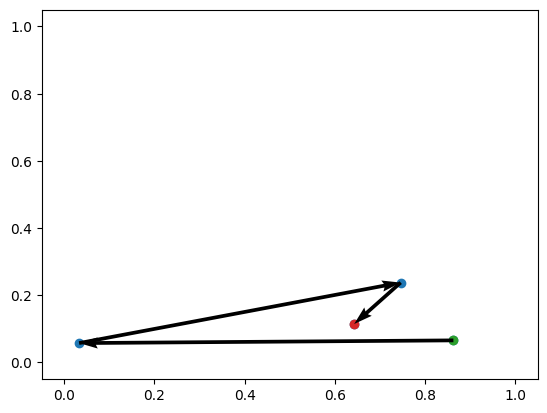

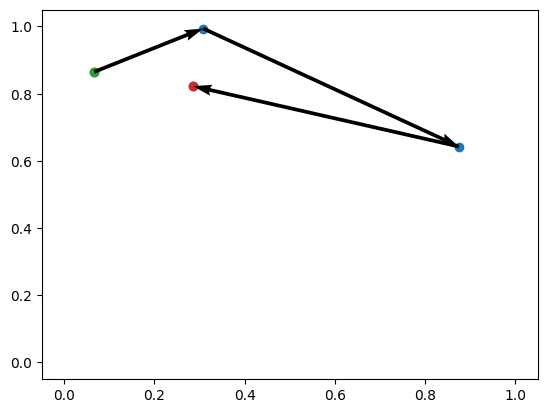

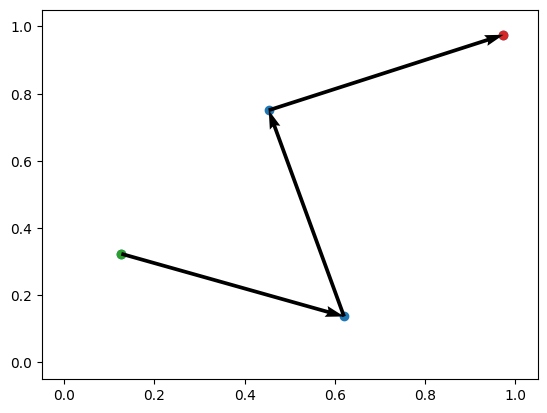

In [200]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [201]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead


current node:  tensor([[0],
        [3],
        [8],
        [5],
        [1],
        [6],
        [6],
        [1],
        [0],
        [6],
        [0],
        [9],
        [9],
        [1],
        [8],
        [7],
        [5],
        [7],
        [5],
        [6],
        [4],
        [7],
        [2],
        [0],
        [3],
        [0],
        [4],
        [4],
        [7],
        [0],
        [6],
        [5],
        [9],
        [7],
        [7],
        [1],
        [3],
        [0],
        [6],
        [1],
        [3],
        [9],
        [0],
        [5],
        [4],
        [9],
        [5],
        [8],
        [3],
        [1],
        [2],
        [0],
        [5],
        [1],
        [4],
        [2],
        [0],
        [1],
        [7],
        [3],
        [7],
        [7],
        [8],
        [6],
        [0],
        [0],
        [5],
        [9],
        [4],
        [3],
        [1],
        [0],
        [9],
        [2],
        [0],
        [4

RuntimeError: batch dimension mismatch, got self.batch_size=torch.Size([512]) and value.shape=torch.Size([]).

current node:  tensor([[ 4],
        [12],
        [ 0]], device='cuda:0')
index:  tensor([[0],
        [0],
        [0]], device='cuda:0')
first node:  tensor([0, 0, 0], device='cuda:0')
end node:  tensor([18, 18, 18], device='cuda:0')
action mask:  tensor([[ True,  True,  True,  True, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True]],
       device='cuda:0')
tensor([False, False, False], device='cuda:0')
done:  tensor([[False],
        [False],
        [False]], device='cuda:0')
current node:  tensor([[14],
        [ 9],
        [ 4]], device='cuda:0')
index:  tensor([[1],
        [1],
        [1]], d

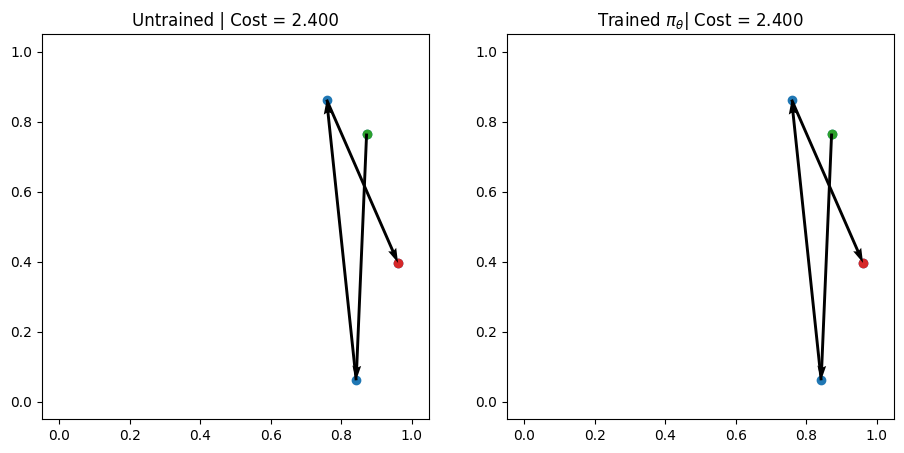

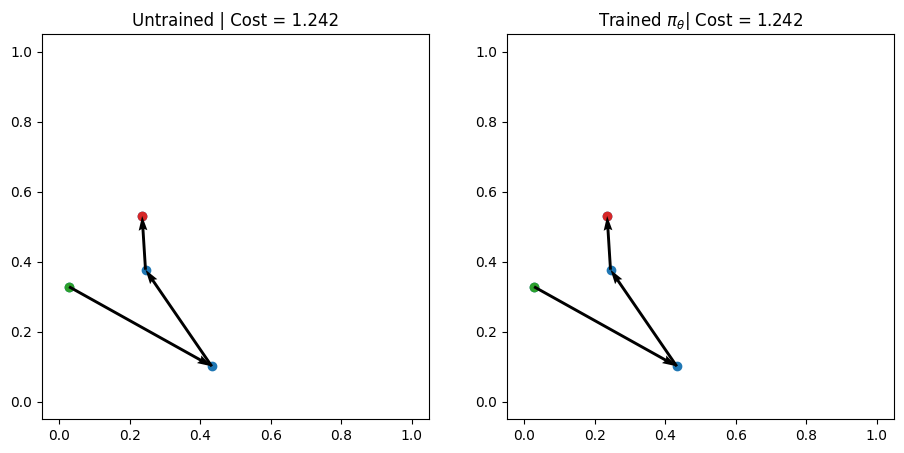

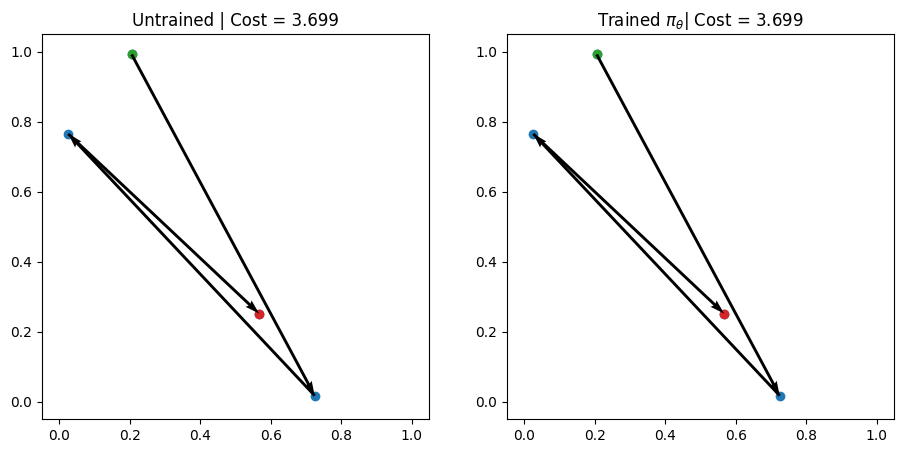

In [21]:
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")